# Trouver la position des ennemis

Nous nous situons dans le cadre de la coupe de France de robotique 2019. On a un robot capable de se mouvoir sur une table de 2 mètres sur 3. On a aussi un LiDAR qui peut prendre des mesures à 360°. On peut donc observer notre environnement immédiat dans un plan donné. Et si on trouvait des robots ennemis sur la table ?

On va commencer par mettre en place notre environnement de travail, puis on va situer notre robot et le robot adverse sur la table. Ensuite, on va faire comme si on avait repéré le robot adverse avec le LiDAR. Enfin, on va redonner sa position dans le repère de la table pour que cette information soit utilisée par le haut-niveau (la partie *preneuse de décision* du robot).

## Environnement de travail

On importe ce qu'il faut : 
- *numpy* pour faire du calcul matriciel, 
- *matplolib* avec *pyplot* pour afficher des graphiques.


In [1]:
import numpy as np
import matplotlib.pyplot as pl
pl.figure(figsize=(15,13))

# %matplotlib inline
%matplotlib notebook

On importe depuis la racine le code du projet nécessaire pour ce *notebook*.

In [2]:
from lidarproc.main.constants import *
import lidarproc.main.clustering as clus
import lidarproc.main.data_cleansing as dacl
import lidarproc.main.output_rendering as outr
from lidarproc.retrieve_realistic_measures import get_table_measures
import lidarproc.check_hough as chh
import lidarproc.check_clustering as chc
from lidarproc.main.geometry import Point, Vector
from lidarproc.main.table import Square, Table

## Instanciation

On suppose connaître la position et l'orientation absolues du robot. On définit $\begin{pmatrix}x_{soi} \\\ y_{soi}\end{pmatrix} = \begin{pmatrix} 750 \\\ 500 \end{pmatrix}$ et $\theta = \frac{\pi}{3}$

In [3]:
robot_position = Point(750, 500)
orientation = np.pi/3

On initialise la position du robot ennemi $\begin{pmatrix}x_{ennemi} \\ y_{ennemi}\end{pmatrix} = \begin{pmatrix} -200 \\\ 1230 \end{pmatrix}$, mais elle nous est cachée.

In [4]:
opponent_position = Point(-200, 1230)

Notre robot perçoit le robot ennemi selon la distance les séparant et l'orientation relative de notre robot. Nous mesurons donc la position relative du robot adverse par rapport à notre robot.

In [5]:
vect_between_it_and_me = Vector()
vect_between_it_and_me.set_by_points(robot_position, opponent_position)
perceived_angle = vect_between_it_and_me.compute_basis_angle() - orientation
perceived_distance = vect_between_it_and_me.compute_distance()

In [6]:
perceived_angle, perceived_distance

(1.4392083819601436, 1198.0818002123228)

En coordonnées cartésiennes dans le repère du robot, ça donne :

In [7]:
np.cos(perceived_angle)*perceived_distance, np.sin(perceived_angle)*perceived_distance

(157.19854476264027, 1187.724133595217)

Affichage de la situation du point de vue de la table.

vectors
750 500
points
-200 1230
750 500


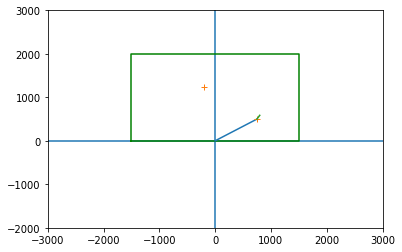

In [8]:
%matplotlib inline

# table instantiation
table = Table()

# table edges
table.add_edge_point(Point(-1500, 0))
table.add_edge_point(Point(1500, 0))
table.add_edge_point(Point(1500, 2000))
table.add_edge_point(Point(-1500, 2000))

# adds opponent robot
table.add_point(opponent_position)

# adds our robot
v_robot_position = Vector()
v_robot_position.set_by_point(robot_position)
table.add_vector(v_robot_position)
table.add_point(robot_position)

# displays all
table.init_plot()
table.plot_edges()
table.plot_vectors()
table.plot_points()
table.plot_unitary_vector(robot_position, orientation)
table.plot()

## Mise en situation

Passage du point de vue de la table (absolu) au point de vue du robot (relatif).

**Relation fondamentale du changement de repère** :

$$\begin{pmatrix}x_{absolu} \\\ y_{absolu}\end{pmatrix} = R(\theta) \times (\begin{pmatrix}x_{relatif} \\\ y_{relatif}\end{pmatrix} - \begin{pmatrix}x_{soi} \\\ y_{soi}\end{pmatrix})$$

avec
- $\begin{pmatrix}x_{absolu} \\\ y_{absolu}\end{pmatrix}$ une position dans le repère de la table,
- $R(\theta)$ la matrice de rotation d'angle $\theta$, $R(\theta) = \begin{pmatrix}cos(\theta) & -sin(\theta) \\\ sin(\theta) & cos(\theta) \end{pmatrix}$
- $\begin{pmatrix} x_{relatif} \\\ y_{relatif} \end{pmatrix}$ position dans le repère du robot (mesure prise avec le LiDAR),
- $\begin{pmatrix}x_{soi} \\\ y_{soi}\end{pmatrix}$ position du robot dans le repère de la table.

In [9]:
opponent_position_from_robot = opponent_position.copy()
opponent_position_from_robot = opponent_position_from_robot - robot_position
opponent_position_from_robot.rotate(orientation)

robot_position_from_robot = robot_position.copy()
robot_position_from_robot = robot_position_from_robot - robot_position
robot_position_from_robot.rotate(orientation)

Affichage du point de vue du robot.

vectors
0.0 0.0
points
-1107.1985447626403 -457.72413359521664


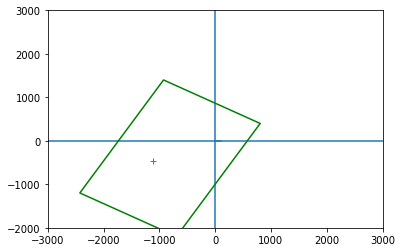

In [10]:
%matplotlib inline

# translation and rotation
v_robot_position_from_robot = Vector()
v_robot_position_from_robot.set_by_point(robot_position_from_robot)


# table instantiation
table = Table()
table.add_edge_point(Point(-1500, 0))
table.add_edge_point(Point(1500, 0))
table.add_edge_point(Point(1500, 2000))
table.add_edge_point(Point(-1500, 2000))

table.translate(-1*v_robot_position)
table.rotate(orientation)

table.add_point(opponent_position_from_robot)

table.add_vector(v_robot_position_from_robot)

table.init_plot()
table.plot_edges()

table.plot_unitary_vector(Point(0, 0), 0)
table.plot_vectors()
table.plot_points()

# table.plot_point(robot_position)
# table.plot_unitary_vector(robot_position, orientation)
# table.plot_point(opponent_position)


# table.plot_measures(measure, vectors, robot_vector)
table.plot()

## Localisation

On se remet dans le repère de la table.

On refait un changement de repère :

$$\begin{pmatrix}x_{absolu} \\\ y_{absolu}\end{pmatrix} = R(-\theta) \times \begin{pmatrix}x_{relatif} \\\ y_{relatif}\end{pmatrix} + \begin{pmatrix}x_{soi} \\\ y_{soi}\end{pmatrix}$$

In [11]:
opponent_position_estimated = opponent_position_from_robot.copy()
opponent_position_estimated.rotate(-orientation)
opponent_position_estimated = opponent_position_estimated + robot_position


robot_position_estimated = robot_position_from_robot.copy()
robot_position_estimated.rotate(-orientation)
robot_position_estimated = robot_position_estimated + robot_position


Reconstitution de la table initiale.

750.0 - 500.0
vectors
750.0 500.0
points
-200.0 1230.0
750.0 500.0


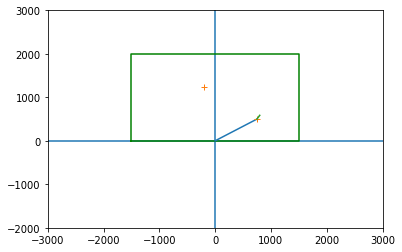

In [12]:
%matplotlib inline

# table instantiation
table = Table()
table.add_edge_point(Point(-1500, 0))
table.add_edge_point(Point(1500, 0))
table.add_edge_point(Point(1500, 2000))
table.add_edge_point(Point(-1500, 2000))

table.add_point(opponent_position_estimated)
table.add_point(robot_position_estimated)


v_robot_position = Vector()
v_robot_position.set_by_point(robot_position_estimated)
print(v_robot_position)
table.add_vector(robot_position_estimated)

table.init_plot()
table.plot_edges()
table.plot_vectors()
table.plot_points()

table.plot_unitary_vector(robot_position_estimated, orientation)

table.plot()

----------------------------------
Par Clément Besnier, [www.clementbesnier.fr](https://www.clementbesnier.fr)